# Federal Funds Rate Forecasting Project: Ensemble Models and Forecasts

This Notebook contain the ensemble models created based on the base models in the previous notebook and the forward looking forecasts for 5 models.

Ensemble Models:

Meta Model: Stacks valid predictions of the two best performing base models (Seq2Seq (univariate), LSTM) and then we perform a ridge regression on the stakced data.

Weighted Ensemble:



In [1]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import files
uploaded = files.upload()


Saving conf_int_dfnn_test.csv to conf_int_dfnn_test.csv
Saving conf_int_dfnn_val.csv to conf_int_dfnn_val.csv
Saving conf_int_test.csv to conf_int_test.csv
Saving conf_int_val.csv to conf_int_val.csv
Saving conf_interval_test.csv to conf_interval_test.csv
Saving conf_interval_val.csv to conf_interval_val.csv
Saving fed_funds_full.csv to fed_funds_full.csv
Saving lstm_forecast3.csv to lstm_forecast3.csv
Saving lstm_forecast12 (2).csv to lstm_forecast12 (2).csv
Saving nnn_predictions_test.csv to nnn_predictions_test.csv
Saving nnn_predictions_valid.csv to nnn_predictions_valid.csv
Saving performance_stat.csv to performance_stat.csv
Saving rffuture12.csv to rffuture12.csv
Saving rffuture60.csv to rffuture60.csv
Saving seq_forecast1.csv to seq_forecast1.csv
Saving seq_forecast12.csv to seq_forecast12.csv
Saving stat_preds_test (3).csv to stat_preds_test (3).csv
Saving stat_preds_val (3).csv to stat_preds_val (3).csv
Saving test_performance (2).csv to test_performance (2).csv
Saving test_pe

## 1. Importing and Viewing all the necessary data files

1. Import all the data files
2. Combine the data files from the different notebooks where necessary
3. Plot valid data with confidence intervals and view valid performance metrics for ensemble model decisions.

In [7]:
nn_predictions_test = pd.read_csv('nnn_predictions_test.csv')
nn_predictions_valid = pd.read_csv('nnn_predictions_valid.csv')
stat_preds_test = pd.read_csv('stat_preds_test (3).csv')
stat_preds_valid = pd.read_csv('stat_preds_val (3).csv')
test_performance = pd.read_csv('test_performance (2).csv')
valid_performance = pd.read_csv('valid_performance (3).csv')
test_performance_nn = pd.read_csv('test_performance_nnn.csv')
valid_performance_nn = pd.read_csv('valid_performance_nnn.csv')
lstm_forecast2 = pd.read_csv('lstm_forecast3.csv')
lstm_forecast12 = pd.read_csv('lstm_forecast12 (2).csv')
conf_int_val = pd.read_csv('conf_int_val.csv')
conf_int_test = pd.read_csv('conf_int_test.csv')
conf_int_dfnn_val = pd.read_csv('conf_int_dfnn_val.csv')
conf_int_dfnn_test = pd.read_csv('conf_int_dfnn_test.csv')
seq_forecast12 = pd.read_csv('seq_forecast12.csv')
rffuture12 = pd.read_csv('rffuture12.csv')


In [8]:
valid_performance = valid_performance[~valid_performance.index.isin([ 'Taylor'])]
test_performance = test_performance[~test_performance.index.isin([ 'Taylor'])]
valid_performance = valid_performance[1:]
test_performance = test_performance[1:]
valid_performance_all = pd.concat([valid_performance, valid_performance_nn])
valid_performance_all.index = [ 'LightGBM', 'Random Forest', 'LSTM', 'GRU', 'SEQ2SEQ_UNI', 'CNNLSTM', 'SEQ2SEQ_VAR']
test_performance_all = pd.concat([test_performance, test_performance_nn])
test_performance_all.index = ['LightGBM', 'Random Forest', 'LSTM', 'GRU', 'SEQ2SEQ_UNI', 'CNNLSTM', 'SEQ2SEQ_VAR']
print(valid_performance_all)
print(test_performance_all)

t_a = test_performance_all[test_performance_all.index.isin(['LSTMT', 'Random Forest', 'LightGBM', 'GRUT', 'Taylor'])]

valid_performance_all.sort_values(by='RMSE')

                   RMSE       MAE        MPE       MAPE
LightGBM       0.525823  0.456333   7.770683  45.438871
Random Forest  0.548122  0.473920  34.442120  40.041882
LSTM           0.178614  0.121606  -1.239038  11.636452
GRU            0.199870  0.139448  -1.396090  12.944352
SEQ2SEQ_UNI    0.151245  0.105041  -4.609933  10.285400
CNNLSTM        0.378671  0.315485 -18.057884  33.265450
SEQ2SEQ_VAR    0.233813  0.164233  -2.005009  14.762129
                   RMSE       MAE         MPE        MAPE
LightGBM       0.284124  0.179518 -159.341864  160.147321
Random Forest  0.183112  0.107954  -74.518646   78.242512
LSTM           0.269778  0.220666  -79.868477   90.822533
GRU            0.355460  0.267100  -71.211289   85.319572
SEQ2SEQ_UNI    0.278963  0.235443  -38.062886   50.577182
CNNLSTM        1.093705  0.960841 -126.516615  176.603910
SEQ2SEQ_VAR    1.742619  1.602484  252.433816  252.433816


,RMSE,MAE,MPE,MAPE
SEQ2SEQ_UNI,0.151245,0.105041,-4.609933,10.285400
LSTM,0.178614,0.121606,-1.239038,11.636452
GRU,0.199870,0.139448,-1.396090,12.944352
SEQ2SEQ_VAR,0.233813,0.164233,-2.005009,14.762129
CNNLSTM,0.378671,0.315485,-18.057884,33.265450
LightGBM,0.525823,0.456333,7.770683,45.438871
Random Forest,0.548122,0.473920,34.442120,40.041882


In [9]:
## Trim Stat predictions to make in match NN models
stat_pred_valid_trim = stat_preds_valid[stat_preds_valid.index > 11].reset_index(drop=True)
stat_pred_test_trim = stat_preds_test[stat_preds_test.index > 11].reset_index(drop=True)
print(stat_pred_valid_trim)


    taylor_estimate  lightgbm  random_forest
0          5.067706  0.645504       0.264278
1          4.930384  0.593450       0.263273
2          4.747086  0.536524       0.247253
3          4.771530  0.525820       0.254142
4          4.871613  0.550970       0.313381
5          4.971454  0.539751       0.287219
6          4.990695  0.534503       0.292824
7          4.648725  0.528597       0.373543
8          4.347848  0.538103       0.380056
9          4.203791  0.550063       0.385699
10         4.177503  0.577789       0.379773
11         4.193558  0.620944       0.491368
12         4.108463  0.642130       0.485809
13         4.132924  0.636494       0.485868
14         4.265430  0.656001       0.523683
15         4.148763  0.652887       0.555354
16         4.174838  0.672341       0.634576
17         4.237357  0.772952       0.719107
18         4.185274  0.862641       0.999272
19         4.551010  0.955772       1.005372
20         4.738103  1.106438       1.065163
21        

In [10]:
predictions_all_valid = pd.concat([nn_predictions_valid, stat_pred_valid_trim], axis=1)
predictions_all_test = pd.concat([nn_predictions_test, stat_pred_test_trim], axis=1)


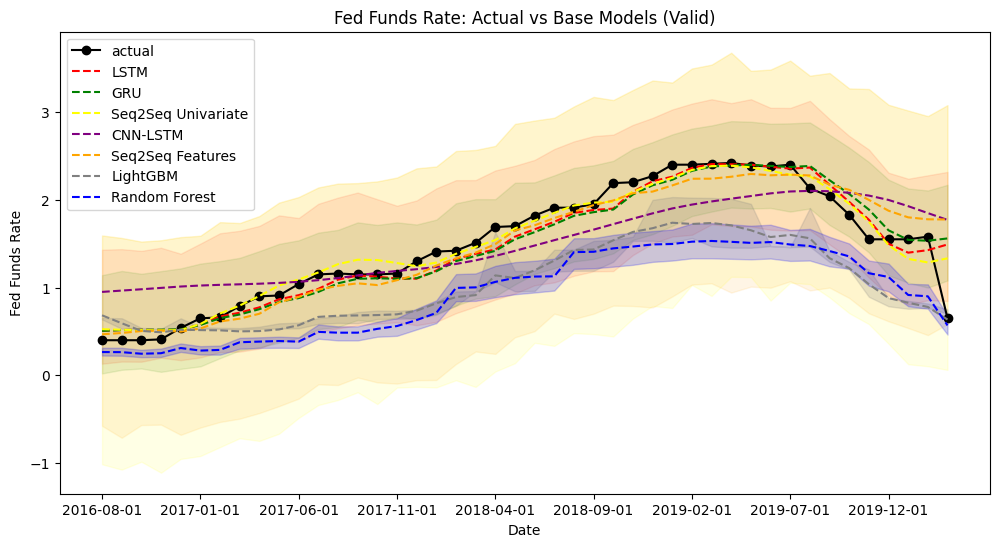

In [32]:
## Plot Valid Data with Confidence Intervals

plt.figure(figsize=(12, 6))
plt.plot(predictions_all_valid['date'], predictions_all_valid['actual'], color = 'black', label='actual', marker = 'o')
plt.plot(predictions_all_valid['date'], predictions_all_valid['lstm'], color = 'red', label='LSTM', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_dfnn_val['lstm_lower'], conf_int_dfnn_val['lstm_upper'], color='red', alpha=0.1)
plt.plot(predictions_all_valid['date'], predictions_all_valid['gru'], color = 'green', label='GRU', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_dfnn_val['gru_lower'], conf_int_dfnn_val['gru_upper'], color='green', alpha=0.1)
plt.plot(predictions_all_valid['date'], predictions_all_valid['seq2seq_uni'], color = 'yellow', label='Seq2Seq Univariate', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_dfnn_val['seq2sequ_lower'], conf_int_dfnn_val['seq2seq_upper'], color='yellow', alpha=0.1)
plt.plot(predictions_all_valid['date'], predictions_all_valid['cnnlstm'], color = 'purple', label='CNN-LSTM', linestyle = '--')
plt.plot(predictions_all_valid['date'], predictions_all_valid['seq2seq_var'], color = 'orange', label='Seq2Seq Features', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_dfnn_val['seq2seq_lower'], conf_int_dfnn_val['seq2seq_upper'], color='orange', alpha=0.1)
plt.plot(predictions_all_valid['date'], predictions_all_valid['lightgbm'], color = 'gray', label='LightGBM', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_val['lgb_lower'][12:], conf_int_val['lgb_upper'][12:], color='gray', alpha=.2)
plt.plot(predictions_all_valid['date'], predictions_all_valid['random_forest'], color = 'blue', label='Random Forest', linestyle = '--')
plt.fill_between(predictions_all_valid['date'], conf_int_val['rf_lower'][12:], conf_int_val['rf_upper'][12:], color='blue', alpha=.2)
plt.xlabel('Date')
plt.xticks(predictions_all_valid['date'][::5])
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Actual vs Base Models (Valid)')

plt.legend()

plt.show()

## 2. Ensemble Models


Meta Model: Stacks valid predictions of the two best performing base models (Seq2Seq (univariate), LSTM) and then we perform a ridge regression on the stakced data. We use a GridSearchCV to find the best alpha value ie L2 regularization.

Weighted Ensemble: Weighted average of valid predictions for Seq2Seq (univariate) and LSTM based on RMSE. Weights come out to 46% LSTM and 54% Seq2Seq. I also do it for all the models as a baseline.

In [7]:
## Stack for Meta Model

X_train_meta2 = np.column_stack((predictions_all_valid['lstm'], predictions_all_valid['seq2seq_uni']))
y_train_meta2 = predictions_all_valid['actual']
X_test_meta2 = np.column_stack((predictions_all_test['lstm'], predictions_all_test['seq2seq_uni']))

In [8]:
## Ridge regression on valid predictions with grid search
alpha_values = np.logspace(-4, 4, 9) ## Grid
ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model, param_grid={'alpha': alpha_values}, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_meta2, y_train_meta2)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")

best_model = grid_search.best_estimator_
meta_predictions2 = best_model.predict(X_test_meta2)

Best Alpha: 0.1


In [9]:
## Storing test metrics

meta_test2_RMSE = np.sqrt(np.mean((predictions_all_test['actual'] - meta_predictions2)**2))
meta_test2_MAE = np.mean(np.abs((predictions_all_test['actual'] - meta_predictions2)))
meta_test2_MPE = np.mean((predictions_all_test['actual'] - meta_predictions2) / predictions_all_test['actual']) * 100
meta_test2_MAPE = np.mean(np.abs((predictions_all_test['actual'] - meta_predictions2) / predictions_all_test['actual'])) * 100


In [10]:
## Weighted Ensemble all

valid_all = valid_performance_all[valid_performance_all.index.isin(['LightGBM', 'Random Forest', 'LSTM', 'GRU', 'SEQ2SEQ_UNI', 'CNNLSTM', 'SEQ2SEQ_VAR' ])]
valid_all

weights =1/valid_all['RMSE']
weights/= weights.sum()
weights

,RMSE
LightGBM,0.073021
Random Forest,0.064831
LSTM,0.200024
GRU,0.178752
SEQ2SEQ_UNI,0.236221
CNNLSTM,0.094349
SEQ2SEQ_VAR,0.152803


In [11]:
## Weighted Ensemble equation
weighted_valid = weights[0] * predictions_all_valid['lightgbm'] + weights[1] * predictions_all_valid['random_forest'] + weights[2] * predictions_all_valid['lstm'] + weights[3] * predictions_all_valid['gru'] + weights[4] * predictions_all_valid['seq2seq_uni'] + weights[5] * predictions_all_valid['cnnlstm'] + weights[6] * predictions_all_valid['seq2seq_uni']

<ipython-input-11-6992d5e5288d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_valid = weights[0] * predictions_all_valid['lightgbm'] + weights[1] * predictions_all_valid['random_forest'] + weights[2] * predictions_all_valid['lstm'] + weights[3] * predictions_all_valid['gru'] + weights[4] * predictions_all_valid['seq2seq_uni'] + weights[5] * predictions_all_valid['cnnlstm'] + weights[6] * predictions_all_valid['seq2seq_uni']


In [12]:
## Valid for weighted ensemble all models

weight_valid_RMSE = np.sqrt(np.mean((predictions_all_valid['actual'] - weighted_valid)**2))
weight_valid_MAE = np.mean(np.abs((predictions_all_valid['actual'] - weighted_valid)))
weight_valid_MPE = np.mean((predictions_all_valid['actual'] - weighted_valid) / predictions_all_valid['actual']) * 100
weight_valid_MAPE = np.mean(np.abs((predictions_all_valid['actual'] - weighted_valid) / predictions_all_valid['actual'])) * 100
print('WEIGHTED VALID RMSE:', weight_valid_RMSE)
print('WEIGHTED VALID  MAE:', weight_valid_MAE)
print('WEIGHTED VALID  MPE:', weight_valid_MPE)
print('WEIGHTED VALID MAPE:', weight_valid_MAPE)

WEIGHTED VALID RMSE: 0.18845189314737926
WEIGHTED VALID  MAE: 0.1501610829986452
WEIGHTED VALID  MPE: 0.5506270293677915
WEIGHTED VALID MAPE: 12.956495299149


In [12]:
## Test data if needed
weighted_test = weights[0] * predictions_all_test['lightgbm'] + weights[1] * predictions_all_test['random_forest'] + weights[2] * predictions_all_test['lstm'] + weights[3] * predictions_all_test['gru_t'] + weights[4] * predictions_all_test['seq2seq_uni'] + weights[5] * predictions_all_test['cnnlstm'] + weights[6] * predictions_all_test['seq2seq_var']

<ipython-input-12-3fbcff244d60>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_test = weights[0] * predictions_all_test['lightgbm'] + weights[1] * predictions_all_test['random_forest'] + weights[2] * predictions_all_test['lstm'] + weights[3] * predictions_all_test['gru_t'] + weights[4] * predictions_all_test['seq2seq_uni'] + weights[5] * predictions_all_test['cnnlstm'] + weights[6] * predictions_all_test['seq2seq_var']


In [14]:

## Storing test metrics if needed
weight_test_RMSE = np.sqrt(np.mean((predictions_all_test['actual'] - weighted_test)**2))
weight_test_MAE = np.mean(np.abs((predictions_all_test['actual'] - weighted_test)))
weight_test_MPE = np.mean((predictions_all_test['actual'] - weighted_test) / predictions_all_test['actual']) * 100
weight_test_MAPE = np.mean(np.abs((predictions_all_test['actual'] - weighted_test) / predictions_all_test['actual'])) * 100


In [17]:
## Best two base models weighted ensemble weightings
valid_performance_best = valid_performance_all[valid_performance_all.index.isin(['LSTM', 'SEQ2SEQ_UNI'])]

weights2 =1/valid_performance_best['RMSE']
weights2/= weights2.sum()
weights2

,RMSE
LSTM,0.458513
SEQ2SEQ_UNI,0.541487


In [18]:
## Best weighted ensemble equation
weighted_valid2 = weights2[0] * predictions_all_valid['lstm'] + weights2[1] * predictions_all_valid['seq2seq_uni']

<ipython-input-18-28a59c7963e5>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_valid2 = weights2[0] * predictions_all_valid['lstm'] + weights2[1] * predictions_all_valid['seq2seq_uni']


In [23]:

## Valid metric for best weighted ensemble
weight_valid2_RMSE = np.sqrt(np.mean((predictions_all_valid['actual'] - weighted_valid2)**2))
weight_valid2_MAE = np.mean(np.abs((predictions_all_valid['actual'] - weighted_valid2)))
weight_valid2_MPE = np.mean((predictions_all_valid['actual'] - weighted_valid2) / predictions_all_valid['actual']) *100
weight_valid2_MAPE = np.mean(np.abs((predictions_all_valid['actual'] - weighted_valid2) / predictions_all_valid['actual'])) *100
print('WEIGHTED VALID2 RMSE:', weight_valid2_RMSE)
print('WEIGHTED VALID2  MAE:', weight_valid2_MAE)
print('WEIGHTED VALID2  MPE:', weight_valid2_MPE)
print('WEIGHTED VALID2 MAPE:', weight_valid2_MAPE)

WEIGHTED VALID2 RMSE: 0.15700992082690396
WEIGHTED VALID2  MAE: 0.10498564970939986
WEIGHTED VALID2  MPE: -3.0643330698482494
WEIGHTED VALID2 MAPE: 10.248190878695823


In [19]:
## Best Weighted Ensemble Test
weighted_test2 = weights2[0]*predictions_all_test['lstm'] + weights2[1]*predictions_all_test['seq2seq_uni']


<ipython-input-19-75ca2bb8cbac>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_test2 = weights2[0]*predictions_all_test['lstm'] + weights2[1]*predictions_all_test['seq2seq_uni']


In [21]:

## Storing best weighted ensemble valid performance metrics
weight_test2_RMSE = np.sqrt(np.mean((predictions_all_test['actual'] - weighted_test2)**2))
weight_test2_MAE = np.mean(np.abs((predictions_all_test['actual'] - weighted_test2)))
weight_test2_MPE = np.mean((predictions_all_test['actual'] - weighted_test2) / predictions_all_test['actual']) *100
weight_test2_MAPE = np.mean(np.abs((predictions_all_test['actual'] - weighted_test2) / predictions_all_test['actual'])) *100



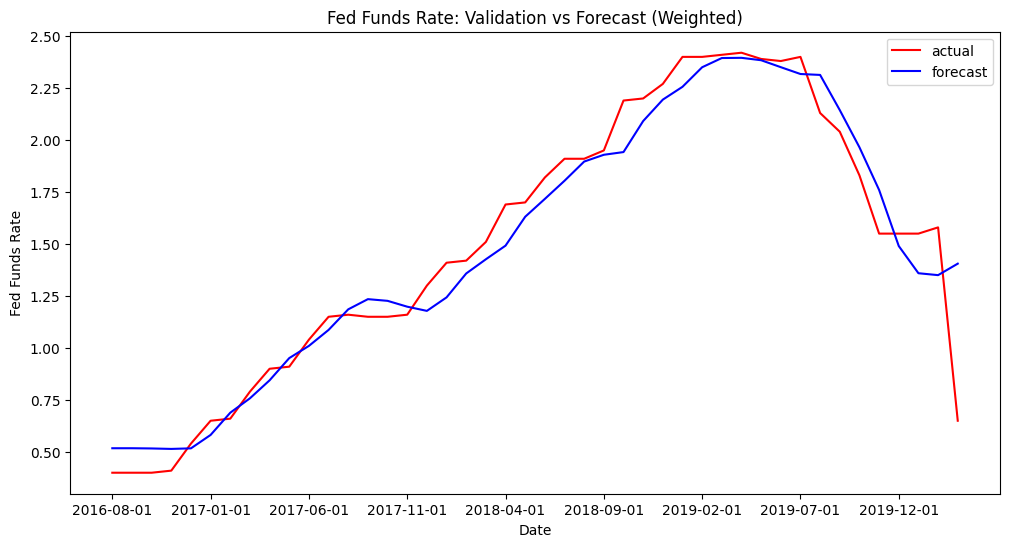

In [26]:
## Plot valid best weighted

plt.figure(figsize=(12, 6))
plt.plot(predictions_all_valid['date'], predictions_all_valid['actual'], color = 'r', label='actual')
plt.plot(predictions_all_valid['date'], weighted_valid2, color='b',  label='forecast')
plt.xticks(predictions_all_valid['date'][::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (Weighted)')

plt.legend()

plt.show()



## 3. Test Performance Metrics

Finally, we can now look at the test performance metrics for all the models. The Meta Model has the best percent errors in a sensitive interest rate environment which is why it is the recommended model. Weighted Ensemble, Seq2Seq univariate, and LSTM perform relatively well on both the valid and test. The Random Forest and LightGBM perform considerably better on the test showing inconcsistency between different economic periods, but can be an applicable model when economic factors are driving the Fed Funds Rate.

In [22]:

weighted_ensemble_performancet = {'RMSE': weight_test2_RMSE, 'MAE': weight_test2_MAE, 'MPE': weight_test2_MPE, 'MAPE': weight_test2_MAPE}
meta_performancet = {'RMSE': meta_test2_RMSE, 'MAE': meta_test2_MAE, 'MPE': meta_test2_MPE, 'MAPE': meta_test2_MAPE}

t_a = test_performance_all[test_performance_all.index.isin(['LSTM', 'Random Forest', 'LightGBM', 'SEQ2SEQ_UNI', 'SEQ2SEQ_VAR', 'GRU', 'CNNLSTM'])]

In [28]:
full_test = pd.concat([t_a, pd.DataFrame(weighted_ensemble_performancet, index=['Weighted Ensemble']), pd.DataFrame(meta_performancet, index = ['Meta Model'])], axis=0)
full_test= full_test.sort_values(by='RMSE')
full_test

,RMSE,MAE,MPE,MAPE
Random Forest,0.184178,0.108118,-73.826421,77.593551
Meta Model,0.206501,0.165266,-22.919934,34.307287
LightGBM,0.249099,0.172222,-127.858736,130.769316
Weighted Ensemble,0.252185,0.217224,-57.231301,68.470543
LSTM,0.269778,0.220666,-79.868477,90.822533
SEQ2SEQ_UNI,0.278963,0.235443,-38.062886,50.577182
GRU,0.355460,0.267100,-71.211289,85.319572
CNNLSTM,1.093705,0.960841,-126.516615,176.603910
SEQ2SEQ_VAR,1.742619,1.602484,252.433816,252.433816


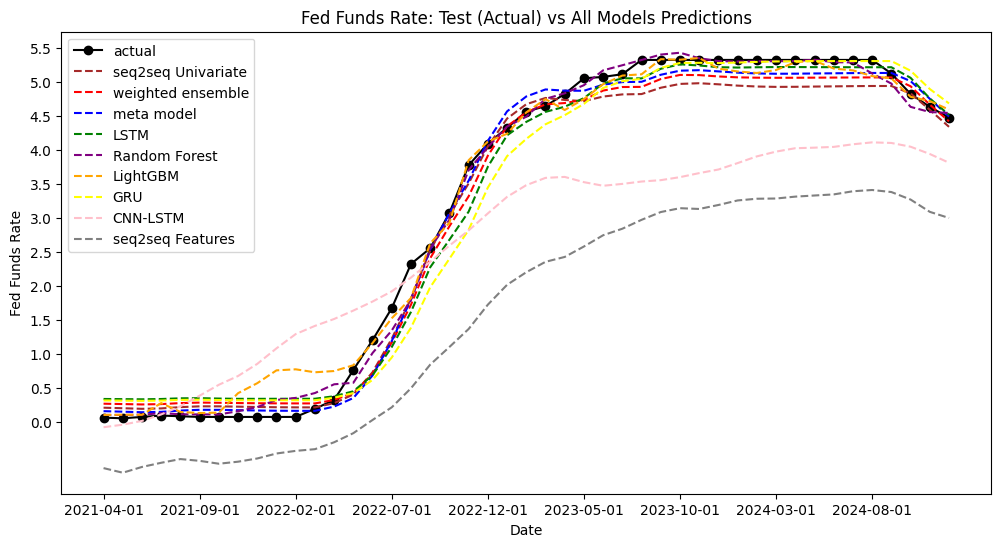

In [31]:
## Test Plot all models
plt.figure(figsize=(12, 6))
plt.plot(predictions_all_test['date'], predictions_all_test['actual'], color = 'black', label='actual', marker = 'o')
plt.plot(predictions_all_test['date'], predictions_all_test['seq2seq_uni'], color = 'brown', label = 'seq2seq Univariate', linestyle = '--')
plt.plot(predictions_all_test['date'], weighted_test2, color='red',  label='weighted ensemble', linestyle = '--')
plt.plot(predictions_all_test['date'], meta_predictions2, color = 'blue', label='meta model', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['lstm'], color = 'green', label='LSTM', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['random_forest'], color = 'purple', label='Random Forest', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['lightgbm'], color = 'orange', label='LightGBM', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['gru_t'], color = 'yellow', label='GRU', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['cnnlstm'], color = 'pink', label='CNN-LSTM', linestyle = '--')
plt.plot(predictions_all_test['date'], predictions_all_test['seq2seq_var'], color = 'gray', label='seq2seq Features', linestyle = '--')

plt.xticks(predictions_all_test['date'][::5])
plt.yticks(np.arange(min(predictions_all_test['actual']-.06), max(predictions_all_test['actual']) + 0.5, 0.5))
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Test (Actual) vs All Models Predictions')

plt.legend()

plt.show()

## 5. Future Forecasts

We now plot the forecasts engineered in previous notebooks. Models predict different Fed Funds rate with Seq2Seq showing the most dramatic fall in EFFR and LSTM showing the lease dramatic fall. Meta Model shows a sharp decline to 1.75% Federal Funds Rate in a year.

In [23]:
seq_forecast1 = seq_forecast12['seqForecast'].iloc[[0, 2]]

lstm_forecast2 = lstm_forecast12['LSTM Forecast'].iloc[[0, 2]]
lstm_forecast2

rffuture1 = rffuture12['rf_forecast'].iloc[[0, 2]]
rffuture1
seq_forecast1


,seqForecast
0,3.981228
2,3.494536


In [24]:

weighted_future12 = weights2[0]*lstm_forecast12['LSTM Forecast'] + weights2[1]*seq_forecast12['seqForecast']
weighted_future2 = weights2[0]*lstm_forecast2 + weights2[1]*seq_forecast1


meta_future12 = best_model.predict(np.column_stack((lstm_forecast12['LSTM Forecast'], seq_forecast12['seqForecast'])))
meta_future12
meta_future2 = meta_future12[0:2]

#

<ipython-input-24-c9109070f007>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_future12 = weights2[0]*lstm_forecast12['LSTM Forecast'] + weights2[1]*seq_forecast12['seqForecast']
<ipython-input-24-c9109070f007>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weighted_future2 = weights2[0]*lstm_forecast2 + weights2[1]*seq_forecast1


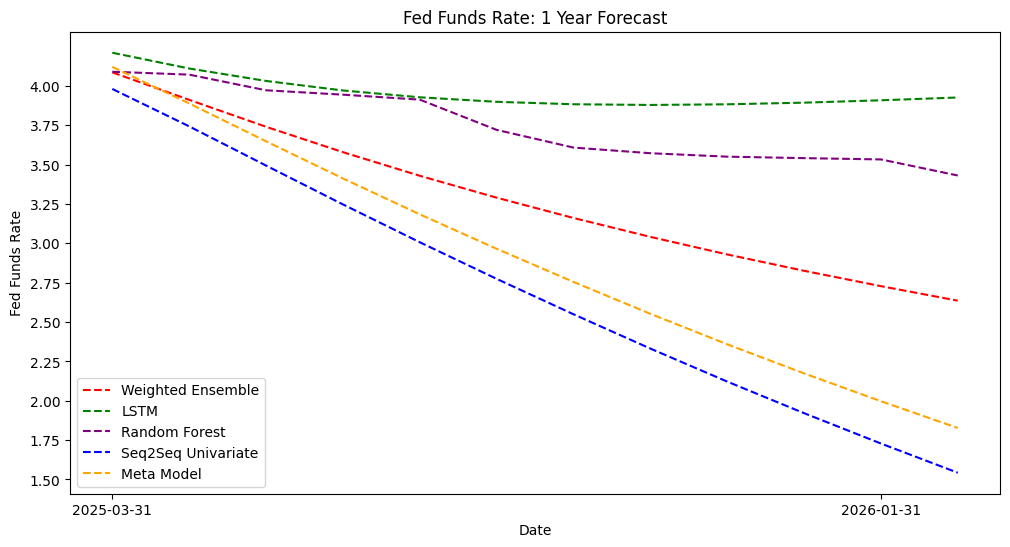

In [25]:
## 1 year forecast

plt.figure(figsize=(12, 6))
plt.plot(lstm_forecast12['Date'], weighted_future12, color = 'red', label='Weighted Ensemble', linestyle = '--')
plt.plot(lstm_forecast12['Date'], lstm_forecast12['LSTM Forecast'], color = 'green', label='LSTM', linestyle = '--')
plt.plot(lstm_forecast12['Date'], rffuture12['rf_forecast'], color = 'purple', label='Random Forest', linestyle = '--')
plt.plot(lstm_forecast12['Date'], seq_forecast12['seqForecast'], color = 'blue', label='Seq2Seq Univariate', linestyle = '--')
plt.plot(lstm_forecast12['Date'], meta_future12, color = 'orange', label='Meta Model', linestyle = '--')

plt.yticks(np.arange(min(seq_forecast12['seqForecast']-.043), max(seq_forecast12['seqForecast']) + 0.25, 0.25))
plt.xticks(lstm_forecast12['Date'][::10])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: 1 Year Forecast')

plt.legend()

plt.show()

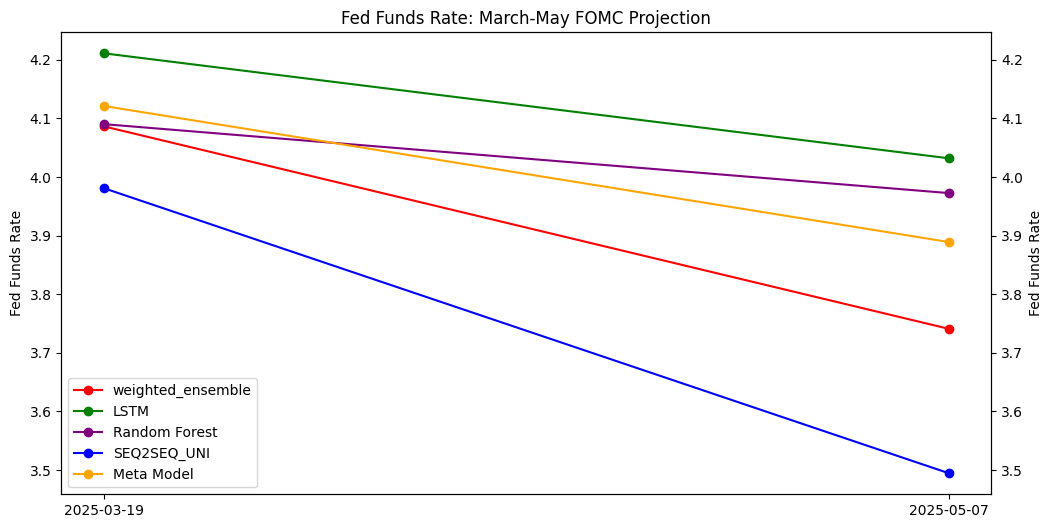

In [128]:
## Next two FOMCs

plt.figure(figsize=(12, 6))
dates = ['2025-03-19', '2025-05-07']
ddates = pd.to_datetime(dates)
ax1 = plt.gca()
ax1.plot(ddates, weighted_future2, color = 'red', label='weighted_ensemble', marker = 'o')
ax1.plot(ddates, lstm_forecast2, color = 'green', label='LSTM', marker = 'o')
ax1.plot(ddates, rffuture1, color = 'purple', label='Random Forest', marker = 'o')
ax1.plot(ddates, seq_forecast1, color = 'blue', label='SEQ2SEQ_UNI', marker = 'o')
ax1.plot(ddates, meta_future2, color = 'orange', label='Meta Model', marker = 'o')
ax1.set_ylabel('Fed Funds Rate')
ax2 = ax1.twinx()
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)
#ax2.set_yticks(np.round(np.linspace(y1_min, y1_max, len(ax1.get_yticks())), 2))

ax2.set_ylabel('Fed Funds Rate')

plt.xlabel('Date')

plt.title('Fed Funds Rate: March-May FOMC Projection')
plt.xticks(ddates, dates)
ax1.legend()

plt.show()